# Notebook 2: Feature engineering

**Objectives**:
- Feature engineering: 
    - Technical indicators (RSI, MACD, Bollinger Bands, etc.)
    - Derived features (returns, momentum, volatility)
    - Time-based features
    - Select relevant features for modeling
---

## Table of Contents

1. [Setup and Configuration](#1-setup-and-configuration)
2. [Load Raw Data](#2-load-raw-data)
3. [Feature Engineering Functions](#3-feature-engineering-functions)
4. [Apply Feature Engineering](#4-apply-feature-engineering)
5. [Handle Missing Values](#5-handle-missing-values)
6. [Data Normalization](#6-data-normalization)
7. [Train/Validation/Test Split](#7-trainvalidationtest-split)
8. [Save Processed Data](#8-save-processed-data)

---

## 1. Setup and Configuration

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import warnings
warnings.filterwarnings('ignore')

# Technical indicators library
import ta

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)

print("[OK] Libraries imported")

[OK] Libraries imported


In [19]:
# Configure plotting styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("[OK] Plotting configuration")

[OK] Plotting configuration


In [20]:
# Define paths and constants
DATA_DIR = '../data_new/'
PROCESSED_DIR = '../data_new/data_processed/'


# Create directories if they don't exist
os.makedirs(PROCESSED_DIR, exist_ok=True)

# Asset information
ASSETS = {
    'AAPL': {'name': 'Apple Inc.', 'type': 'Tech Stock', 'volatility': 'Low-Medium'},
    'AMZN': {'name': 'Amazon.com Inc.', 'type': 'Tech Stock', 'volatility': 'Medium'},
    'NVDA': {'name': 'NVIDIA Corporation', 'type': 'Tech Stock', 'volatility': 'Medium-High'},
    'SPY': {'name': 'S&P 500 ETF', 'type': 'Index ETF', 'volatility': 'Low'},
    'BTC-USD': {'name': 'Bitcoin', 'type': 'Cryptocurrency', 'volatility': 'Very High'}
}

# Prediction horizons (in days)
PREDICTION_HORIZONS_STOCKS = {
    '1day': 1,
    '1week': 5,
    '1month': 20
}

PREDICTION_HORIZONS_CRYPTO  = {
    '1day': 1,
    '1week': 7,
    '1month': 30
}

# File mapping
FILE_NAMES = {
    'AAPL': 'AAPL_1daily_yfinance.csv',
    'AMZN': 'AMZN_1daily_yfinance.csv',
    'NVDA': 'NVDA_1daily_yfinance.csv',
    'SPY': 'SPY_1daily_yfinance.csv',
    'BTC-USD': 'BTC_USD_1daily_yfinance.csv'
}

print("Configuration complete")
print(f"\nAssets to process: {list(ASSETS.keys())}")
print(f"Output directory: {PROCESSED_DIR}")

Configuration complete

Assets to process: ['AAPL', 'AMZN', 'NVDA', 'SPY', 'BTC-USD']
Output directory: ../data_new/data_processed/


## 2. Load Raw Data

Load the cleaned OHLCV data from Notebook 01.

In [21]:
# Load all asset data
data = {}

for asset, filename in FILE_NAMES.items():
    filepath = os.path.join(DATA_DIR, 'data_raw', filename)
    
    try:
        df = pd.read_csv(filepath, index_col=0, parse_dates=True)
        # Standardize column names to lowercase
        df.columns = df.columns.str.lower()
        data[asset] = df
        print(f"[OK] Loaded {asset}: {len(df)} days")
    except FileNotFoundError:
        print(f"[ERROR] File not found: {filepath}")
        data[asset] = None
    except Exception as e:
        print(f"[ERROR] Error loading {asset}: {e}")
        data[asset] = None

print(f"\n[OK] Successfully loaded {sum(1 for v in data.values() if v is not None)}/{len(ASSETS)} assets")

[OK] Loaded AAPL: 6522 days
[OK] Loaded AMZN: 6522 days
[OK] Loaded NVDA: 6522 days
[OK] Loaded SPY: 6522 days
[OK] Loaded BTC-USD: 4101 days

[OK] Successfully loaded 5/5 assets


## 3. Feature Engineering Functions

Define functions to calculate various feature categories.

We saw in the previous notebook that the logreturns were not autocorrelated, indicating that predicting future returns directly may be challenging. Therefore, in this notebook, we will focus on engineering features that capture market dynamics and patterns, which can be more informative for predictive modeling.

We added a bunch of technical indicators using the `ta` library to help capture different aspects of market behavior. The analysis of the correlation between these features and future returns will be done in the next section.

In [22]:
def add_price_features(df):
    """
    Add price-based features.
    """
    df = df.copy()
    
    # Price ratios
    df['close_to_open_ratio'] = df['close'] / df['open']
    df['high_to_low_ratio'] = df['high'] / df['low']
    df['typical_price'] = (df['high'] + df['low'] + df['close']) / 3
    
    # Price ranges
    df['price_range'] = df['high'] - df['low']
    df['price_range_pct'] = df['price_range'] / df['close']
    
    return df

print("[OK] Price features function defined")

[OK] Price features function defined


In [23]:
def add_volume_features(df):
    """
    Add volume-based features.
    """
    df = df.copy()
    
    # Volume changes
    df['volume_change'] = df['volume'].pct_change()
    df['volume_change'] = df['volume_change'].replace([np.inf, -np.inf], 0)
    
    # Volume moving averages
    df['volume_sma_20'] = df['volume'].rolling(window=20).mean()
    df['volume_ratio'] = df['volume'] / df['volume_sma_20']
    
    return df

print("[OK] Volume features function defined")

[OK] Volume features function defined


In [24]:
def add_technical_indicators(df):
    """
    Add comprehensive technical indicators using the ta library.
    """
    df = df.copy()
    
    # Momentum Indicators
    df['rsi_14'] = ta.momentum.RSIIndicator(close=df['close'], window=14).rsi()
    df['rsi_21'] = ta.momentum.RSIIndicator(close=df['close'], window=21).rsi()
    
    # MACD
    macd = ta.trend.MACD(close=df['close'], window_slow=26, window_fast=12, window_sign=9)
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_diff'] = macd.macd_diff()
    
    # Rate of Change
    df['roc_12'] = ta.momentum.ROCIndicator(close=df['close'], window=12).roc()
    df['roc_24'] = ta.momentum.ROCIndicator(close=df['close'], window=24).roc()
    
    # Trend Indicators
    df['sma_20'] = ta.trend.SMAIndicator(close=df['close'], window=20).sma_indicator()
    df['sma_50'] = ta.trend.SMAIndicator(close=df['close'], window=50).sma_indicator()
    df['sma_200'] = ta.trend.SMAIndicator(close=df['close'], window=200).sma_indicator()
    
    df['ema_12'] = ta.trend.EMAIndicator(close=df['close'], window=12).ema_indicator()
    df['ema_26'] = ta.trend.EMAIndicator(close=df['close'], window=26).ema_indicator()
    
    # Price distance from moving averages
    df['close_to_sma20'] = (df['close'] - df['sma_20']) / df['sma_20']
    df['close_to_sma50'] = (df['close'] - df['sma_50']) / df['sma_50']
    
    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
    df['bb_high'] = bollinger.bollinger_hband()
    df['bb_mid'] = bollinger.bollinger_mavg()
    df['bb_low'] = bollinger.bollinger_lband()
    df['bb_width'] = (df['bb_high'] - df['bb_low']) / df['bb_mid']
    df['bb_position'] = (df['close'] - df['bb_low']) / (df['bb_high'] - df['bb_low'])
    
    # ADX (Trend Strength)
    adx = ta.trend.ADXIndicator(high=df['high'], low=df['low'], close=df['close'], window=14)
    df['adx'] = adx.adx()
    
    # Volatility Indicators
    df['atr_14'] = ta.volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=14).average_true_range()
    df['atr_ratio'] = df['atr_14'] / df['close']
    
    # Historical Volatility
    returns = np.log(df['close'] / df['close'].shift(1))
    df['hist_vol_20'] = returns.rolling(window=20).std()
    df['hist_vol_50'] = returns.rolling(window=50).std()
    
    # Volume Indicators
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=df['close'], volume=df['volume']).on_balance_volume()
    df['vwap'] = ta.volume.VolumeWeightedAveragePrice(high=df['high'], low=df['low'], close=df['close'], volume=df['volume']).volume_weighted_average_price()
    df['close_to_vwap'] = (df['close'] - df['vwap']) / df['vwap']
    
    return df

print("[OK] Technical indicators function defined")
print("  - Momentum: RSI, MACD, ROC")
print("  - Trend: SMA, EMA, Bollinger Bands, ADX")
print("  - Volatility: ATR, Historical Volatility")
print("  - Volume: OBV, VWAP")

[OK] Technical indicators function defined
  - Momentum: RSI, MACD, ROC
  - Trend: SMA, EMA, Bollinger Bands, ADX
  - Volatility: ATR, Historical Volatility
  - Volume: OBV, VWAP


In [25]:
def add_returns_features(df):
    """
    Add returns and lagged returns features.
    """
    df = df.copy()
    
    # Log returns
    df['returns'] = np.log(df['close'] / df['close'].shift(1))
    
    # Lagged returns
    for lag in [1, 3, 6, 12, 24]:
        df[f'returns_lag_{lag}'] = df['returns'].shift(lag)
    
    # Cumulative returns
    df['cumulative_returns_24'] = df['returns'].rolling(window=24).sum()
    df['cumulative_returns_168'] = df['returns'].rolling(window=168).sum()
    
    return df

print("[OK] Returns features function defined")

[OK] Returns features function defined


In [26]:
def add_time_features(df):
    """
    Add time-based features with cyclical encoding.
    """
    df = df.copy()
    
    # Extract time components (daily data)
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    
    # Cyclical encoding for day of week (0-6)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # Cyclical encoding for month (1-12)
    df['month_sin'] = np.sin(2 * np.pi * (df['month'] - 1) / 12)
    df['month_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / 12)
    
    return df

print("[OK] Time features function defined")

[OK] Time features function defined


In [27]:
def add_volatility_regime_features(df):
    """
    Add volatility regime classification features.
    """
    df = df.copy()
    
    # Calculate realized volatility (20-day rolling)
    returns = np.log(df['close'] / df['close'].shift(1))
    df['realized_vol_20'] = returns.rolling(window=20).std()
    df['realized_vol_100'] = returns.rolling(window=100).std()
    
    # Volatility ratio
    df['vol_ratio'] = df['realized_vol_20'] / df['realized_vol_100']
    
    # Volatility regime based on percentiles
    vol_percentiles = df['realized_vol_20'].quantile([0.33, 0.67])
    df['vol_regime'] = pd.cut(df['realized_vol_20'], 
                               bins=[0, vol_percentiles.iloc[0], vol_percentiles.iloc[1], np.inf],
                               labels=[0, 1, 2])  # 0=low, 1=medium, 2=high
    df['vol_regime'] = df['vol_regime'].astype(float)
    
    return df

print("[OK] Volatility regime features function defined")

[OK] Volatility regime features function defined


## 4. Apply Feature Engineering

Apply all feature engineering functions to each asset.

In [28]:
# Store engineered features
features_data = {}

print("="*80)
print("FEATURE ENGINEERING PIPELINE")
print("="*80)

for asset, df in data.items():
    print(f"\nProcessing {asset} ({ASSETS[asset]['name']})...")
    
    # Start with copy of original data
    df_features = df.copy()
    initial_rows = len(df_features)
    
    # Apply feature engineering
    print("  - Adding price features...")
    df_features = add_price_features(df_features)
    
    print("  - Adding volume features...")
    df_features = add_volume_features(df_features)
    
    print("  - Adding technical indicators...")
    df_features = add_technical_indicators(df_features)
    
    print("  - Adding returns features...")
    df_features = add_returns_features(df_features)
    
    print("  - Adding time features...")
    df_features = add_time_features(df_features)
    
    print("  - Adding volatility regime features...")
    df_features = add_volatility_regime_features(df_features)
    
    # Drop rows with NaN values (from rolling calculations)
    df_features = df_features.dropna()
    final_rows = len(df_features)
    rows_dropped = initial_rows - final_rows
    
    print(f"  [OK] Feature engineering complete")
    print(f"Initial rows: {initial_rows}")
    print(f"Final rows: {final_rows}")
    print(f"Rows dropped (NaN): {rows_dropped}")
    print(f"Total features: {len(df_features.columns)}")
    
    features_data[asset] = df_features

print("\n" + "="*80)
print("[OK] Feature engineering completed for all assets")
print("="*80)

FEATURE ENGINEERING PIPELINE

Processing AAPL (Apple Inc.)...
  - Adding price features...
  - Adding volume features...
  - Adding technical indicators...
  - Adding returns features...
  - Adding time features...
  - Adding volatility regime features...
  - Adding returns features...
  - Adding time features...
  - Adding volatility regime features...
  [OK] Feature engineering complete
Initial rows: 6522
Final rows: 6323
Rows dropped (NaN): 199
Total features: 61

Processing AMZN (Amazon.com Inc.)...
  - Adding price features...
  - Adding volume features...
  - Adding technical indicators...
  [OK] Feature engineering complete
Initial rows: 6522
Final rows: 6323
Rows dropped (NaN): 199
Total features: 61

Processing AMZN (Amazon.com Inc.)...
  - Adding price features...
  - Adding volume features...
  - Adding technical indicators...
  - Adding returns features...
  - Adding time features...
  - Adding volatility regime features...
  [OK] Feature engineering complete
Initial rows: 

In [29]:
# Display feature summary for one asset
sample_asset = 'AAPL'
print(f"\nFeature Summary for {sample_asset}:")
print("="*60)
print(f"Shape: {features_data[sample_asset].shape}")
print(f"\nColumns ({len(features_data[sample_asset].columns)}):")
for i, col in enumerate(features_data[sample_asset].columns, 1):
    print(f"  {i:2d}. {col}")


Feature Summary for AAPL:
Shape: (6323, 61)

Columns (61):
   1. open
   2. high
   3. low
   4. close
   5. volume
   6. dividends
   7. stock splits
   8. close_to_open_ratio
   9. high_to_low_ratio
  10. typical_price
  11. price_range
  12. price_range_pct
  13. volume_change
  14. volume_sma_20
  15. volume_ratio
  16. rsi_14
  17. rsi_21
  18. macd
  19. macd_signal
  20. macd_diff
  21. roc_12
  22. roc_24
  23. sma_20
  24. sma_50
  25. sma_200
  26. ema_12
  27. ema_26
  28. close_to_sma20
  29. close_to_sma50
  30. bb_high
  31. bb_mid
  32. bb_low
  33. bb_width
  34. bb_position
  35. adx
  36. atr_14
  37. atr_ratio
  38. hist_vol_20
  39. hist_vol_50
  40. obv
  41. vwap
  42. close_to_vwap
  43. returns
  44. returns_lag_1
  45. returns_lag_3
  46. returns_lag_6
  47. returns_lag_12
  48. returns_lag_24
  49. cumulative_returns_24
  50. cumulative_returns_168
  51. day_of_week
  52. day_of_month
  53. month
  54. day_sin
  55. day_cos
  56. month_sin
  57. month_cos
  5

## 5. Create Target Variables

Create binary labels for price movement prediction at multiple horizons.

- Up = close[t+T]-close[t] > 0 = 1
- Down = close[t+T]-close[t] <= 0 = 0

In [30]:
def create_target_variables(df, asset, horizons):
    """
    Create binary target variables for multiple prediction horizons.
    
    Target: 1 if price goes up, 0 if price goes down
    """
    df = df.copy()
    
    targets = {}
    
    for horizon_name, days in horizons.items():
        # Future close price
        future_close = df['close'].shift(-days)
        
        # Binary label: 1 if price increases, 0 if decreases
        target = (future_close > df['close']).astype(int)
        
        # Add to dataframe
        df[f'target_{horizon_name}'] = target
        
        # Store separately
        targets[horizon_name] = target
    
    # Remove last 'max_horizon' rows (no future data)
    max_horizon = max(horizons.values())
    df = df.iloc[:-max_horizon]
    
    return df, targets

print("[OK] Target variable creation function defined")

[OK] Target variable creation function defined


In [31]:
# Create targets for all assets
final_data = {}
target_stats = []

print("="*80)
print("TARGET VARIABLE CREATION")
print("="*80)

for asset, df in features_data.items():
    print(f"\n{asset}:")
    
    # Select appropriate horizons
    horizons = PREDICTION_HORIZONS_CRYPTO if asset == 'BTC-USD' else PREDICTION_HORIZONS_STOCKS
    
    # Create targets
    df_with_targets, targets = create_target_variables(df, asset, horizons)
    
    # Calculate class balance
    for horizon_name in horizons.keys():
        target_col = f'target_{horizon_name}'
        if target_col in df_with_targets.columns:
            value_counts = df_with_targets[target_col].value_counts()
            n_up = value_counts.get(1, 0)
            n_down = value_counts.get(0, 0)
            total = n_up + n_down
            pct_up = (n_up / total * 100) if total > 0 else 0
            
            print(f"  {horizon_name:10s}: UP={n_up:5d} ({pct_up:5.1f}%), DOWN={n_down:5d} ({100-pct_up:5.1f}%)")
            
            target_stats.append({
                'Asset': asset,
                'Horizon': horizon_name,
                'Total': total,
                'UP': n_up,
                'DOWN': n_down,
                'UP_pct': pct_up,
                'Balance': 'Balanced' if 45 <= pct_up <= 55 else 'Imbalanced'
            })
    
    final_data[asset] = df_with_targets

print("\n" + "="*80)
print("[OK] Target variables created for all assets")
print("="*80)

TARGET VARIABLE CREATION

AAPL:
  1day      : UP= 3304 ( 52.4%), DOWN= 2999 ( 47.6%)
  1week     : UP= 3611 ( 57.3%), DOWN= 2692 ( 42.7%)
  1month    : UP= 3933 ( 62.4%), DOWN= 2370 ( 37.6%)

AMZN:
  1day      : UP= 3240 ( 51.4%), DOWN= 3063 ( 48.6%)
  1week     : UP= 3434 ( 54.5%), DOWN= 2869 ( 45.5%)
  1month    : UP= 3796 ( 60.2%), DOWN= 2507 ( 39.8%)

NVDA:
  1day      : UP= 3271 ( 51.9%), DOWN= 3032 ( 48.1%)
  1week     : UP= 3488 ( 55.3%), DOWN= 2815 ( 44.7%)
  1month    : UP= 3721 ( 59.0%), DOWN= 2582 ( 41.0%)

SPY:
  1day      : UP= 3447 ( 54.7%), DOWN= 2856 ( 45.3%)
  1week     : UP= 3683 ( 58.4%), DOWN= 2620 ( 41.6%)
  1month    : UP= 4099 ( 65.0%), DOWN= 2204 ( 35.0%)

BTC-USD:
  1day      : UP= 2048 ( 52.9%), DOWN= 1824 ( 47.1%)
  1week     : UP= 2143 ( 55.3%), DOWN= 1729 ( 44.7%)
  1month    : UP= 2249 ( 58.1%), DOWN= 1623 ( 41.9%)

[OK] Target variables created for all assets


**Remarks:**
- all assets show an upward bias that increases with longer horizons. This trend is actually visible on the price charts as well (notebook 1)
- 1day horizon is nearly balanced for stocks but not for BTC
- 1month horizon is quite imbalanced for all assets
- even if bitcoin is known for its volatility, it still shows an upward bias over time

**Regarding deep learning models:**
- For classification tasks, imbalanced datasets can lead to biased models that favor the majority class. We can use techniques such as resampling (oversampling the minority class or undersampling the majority class), using different evaluation metrics (like F1-score, precision-recall curves), or applying class weights during model training can help address this issue.


In [32]:
# Display target statistics summary
target_stats_df = pd.DataFrame(target_stats)
print("\nTarget Variable Statistics:")
print("="*80)
print(target_stats_df.to_string(index=False))


Target Variable Statistics:
  Asset Horizon  Total   UP  DOWN    UP_pct    Balance
   AAPL    1day   6303 3304  2999 52.419483   Balanced
   AAPL   1week   6303 3611  2692 57.290179 Imbalanced
   AAPL  1month   6303 3933  2370 62.398858 Imbalanced
   AMZN    1day   6303 3240  3063 51.404093   Balanced
   AMZN   1week   6303 3434  2869 54.481993   Balanced
   AMZN  1month   6303 3796  2507 60.225290 Imbalanced
   NVDA    1day   6303 3271  3032 51.895923   Balanced
   NVDA   1week   6303 3488  2815 55.338728 Imbalanced
   NVDA  1month   6303 3721  2582 59.035380 Imbalanced
    SPY    1day   6303 3447  2856 54.688244   Balanced
    SPY   1week   6303 3683  2620 58.432492 Imbalanced
    SPY  1month   6303 4099  2204 65.032524 Imbalanced
BTC-USD    1day   3872 2048  1824 52.892562   Balanced
BTC-USD   1week   3872 2143  1729 55.346074 Imbalanced
BTC-USD  1month   3872 2249  1623 58.083678 Imbalanced


## 6. Feature Correlation Analysis

Analyze correlations between features to identify redundancy and relationships.

In [33]:
# Select numeric features only (exclude target variables and categorical)
def get_feature_columns(df):
    """
    Get list of feature columns (exclude OHLCV and targets).
    """
    exclude_cols = ['open', 'high', 'low', 'close', 'volume'] + \
                   [col for col in df.columns if col.startswith('target_')]
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Select only numeric columns to avoid datetime issues
    feature_cols = [col for col in feature_cols if pd.api.types.is_numeric_dtype(df[col])]
    
    return feature_cols

# Calculate correlation matrix for one asset
sample_asset = 'AAPL'
feature_cols = get_feature_columns(final_data[sample_asset])
correlation_matrix = final_data[sample_asset][feature_cols].corr()

print(f"Feature correlation matrix calculated for {sample_asset}")
print(f"Size: {correlation_matrix.shape}")

Feature correlation matrix calculated for AAPL
Size: (56, 56)


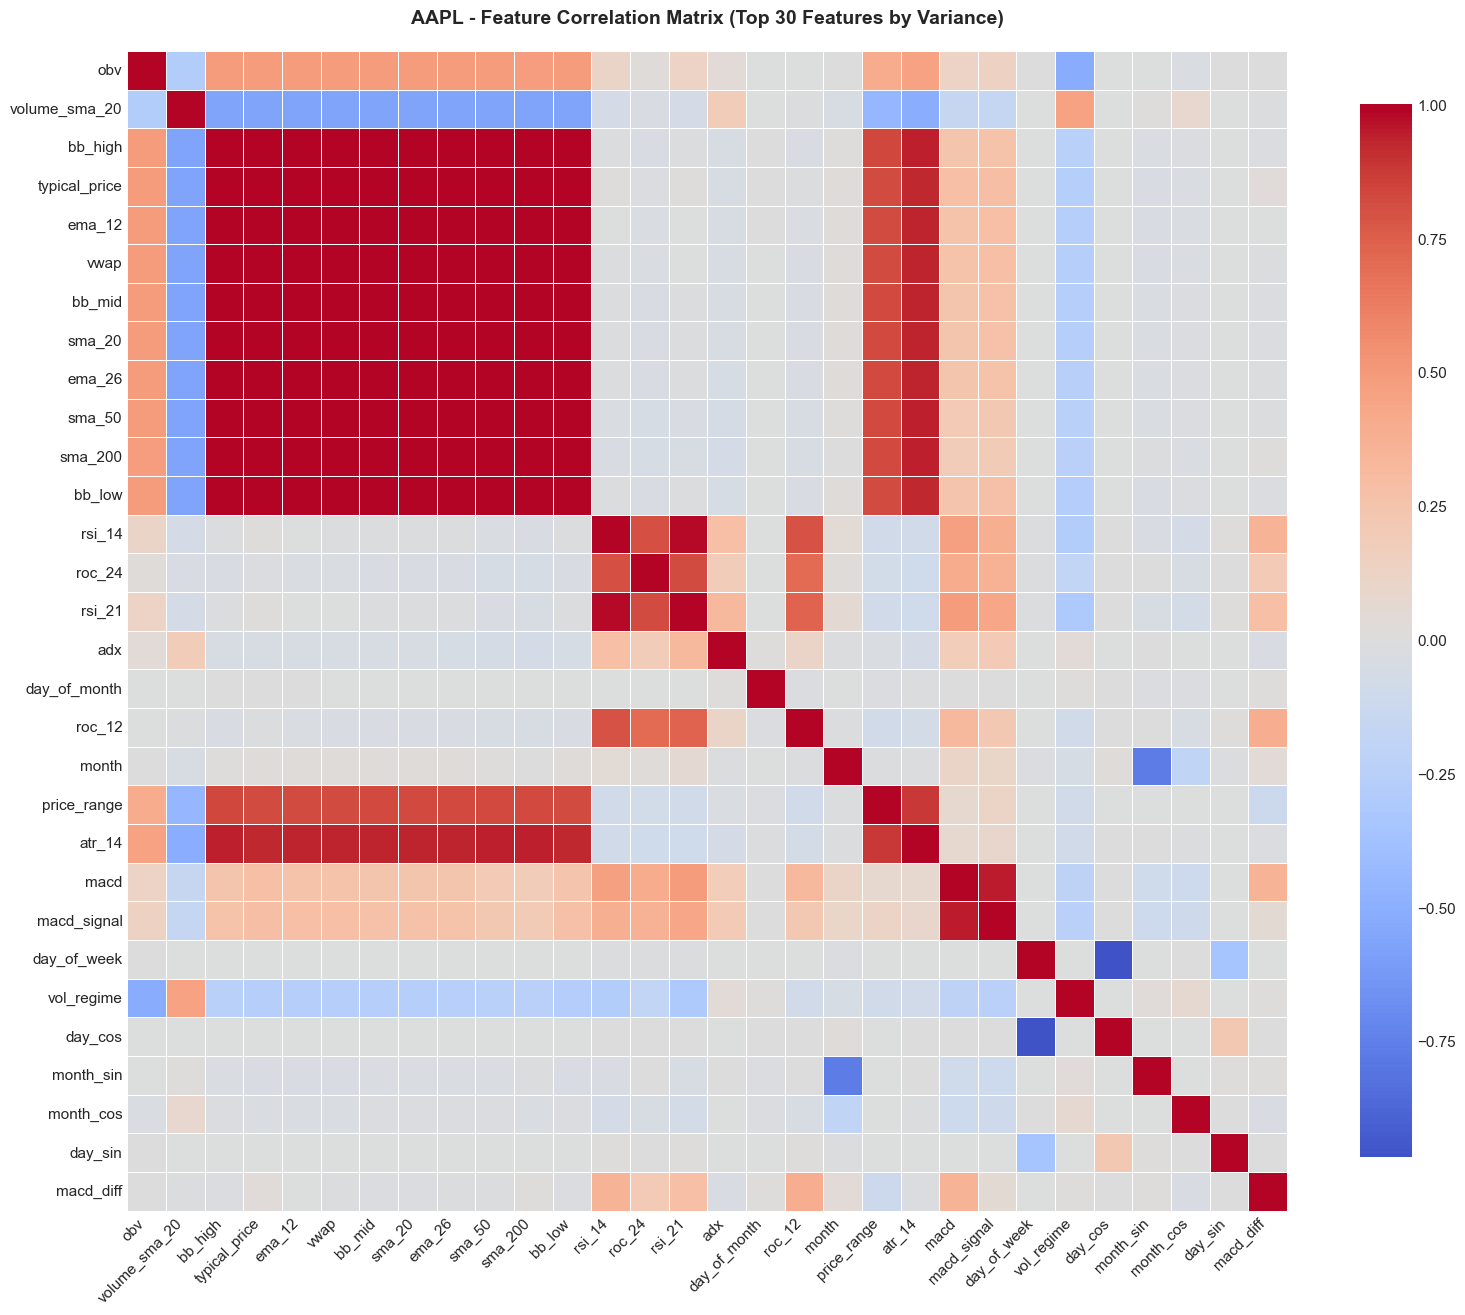

[OK] Correlation heatmap saved


In [39]:
# Plot correlation heatmap (top features by variance)
# Select top 30 features with highest variance
feature_variance = final_data[sample_asset][feature_cols].var().sort_values(ascending=False)
top_features = feature_variance.head(30).index.tolist()

fig, ax = plt.subplots(figsize=(16, 14))
corr_subset = correlation_matrix.loc[top_features, top_features]
sns.heatmap(corr_subset, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            xticklabels=True, yticklabels=True)
ax.set_title(f'{sample_asset} - Feature Correlation Matrix (Top 30 Features by Variance)', 
             fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("[OK] Correlation heatmap saved")

In [35]:
# Find highly correlated feature pairs (|correlation| > 0.9)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.9:
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': corr_value
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False, key=abs)
    print(f"\nHighly Correlated Feature Pairs (|r| > 0.9) for {sample_asset}:")
    print("="*80)
    print(high_corr_df.to_string(index=False))
    print(f"\nTotal pairs: {len(high_corr_pairs)}")
else:
    print(f"\nNo highly correlated feature pairs (|r| > 0.9) found for {sample_asset}")


Highly Correlated Feature Pairs (|r| > 0.9) for AAPL:
        Feature 1             Feature 2  Correlation
      hist_vol_20       realized_vol_20     1.000000
           sma_20                bb_mid     1.000000
           ema_12                  vwap     0.999927
           sma_20                ema_26     0.999915
           ema_26                bb_mid     0.999915
           bb_mid                  vwap     0.999839
           sma_20                  vwap     0.999839
           sma_20                ema_12     0.999767
           ema_12                bb_mid     0.999767
           ema_12                ema_26     0.999754
           ema_26                  vwap     0.999741
          bb_high                bb_mid     0.999573
           sma_20               bb_high     0.999573
           ema_26               bb_high     0.999551
    typical_price                ema_12     0.999511
           sma_20                bb_low     0.999462
           bb_mid                bb_low     

## 7. Feature-Target Correlation Analysis

Analyze which features have the strongest correlation with target variables.

In [36]:
# Calculate feature-target correlations
def calculate_feature_target_correlation(df, horizon):
    """
    Calculate correlation between features and target variable.
    """
    target_col = f'target_{horizon}'
    if target_col not in df.columns:
        return None
    
    feature_cols = get_feature_columns(df)
    correlations = df[feature_cols].corrwith(df[target_col]).sort_values(ascending=False, key=abs)
    
    return correlations

# Calculate for all horizons
horizons = PREDICTION_HORIZONS_STOCKS
feature_target_corr = {}

print(f"Feature-Target Correlations for {sample_asset}:")
print("="*80)

for horizon_name in horizons.keys():
    corr = calculate_feature_target_correlation(final_data[sample_asset], horizon_name)
    if corr is not None:
        feature_target_corr[horizon_name] = corr
        
        print(f"\n{horizon_name.upper()} Prediction Horizon:")
        print("-" * 60)
        print("Top 10 Positively Correlated Features:")
        print(corr.head(10).to_string())
        print("\nTop 10 Negatively Correlated Features:")
        print(corr.tail(10).to_string())

Feature-Target Correlations for AAPL:

1DAY Prediction Horizon:
------------------------------------------------------------
Top 10 Positively Correlated Features:
hist_vol_50              -0.041087
atr_ratio                -0.041028
realized_vol_20          -0.040009
hist_vol_20              -0.040009
realized_vol_100         -0.036692
close_to_open_ratio      -0.035231
day_sin                  -0.031361
vol_regime               -0.029445
cumulative_returns_168    0.029084
bb_width                 -0.028869

Top 10 Negatively Correlated Features:
returns_lag_24    0.003743
close_to_vwap    -0.002782
day_of_month     -0.002781
macd             -0.002516
macd_signal      -0.002317
month             0.002316
volume_ratio      0.002152
returns_lag_6     0.001975
volume_change     0.001263
macd_diff        -0.001139

1WEEK Prediction Horizon:
------------------------------------------------------------
Top 10 Positively Correlated Features:
atr_ratio         -0.064545
hist_vol_50       -0.

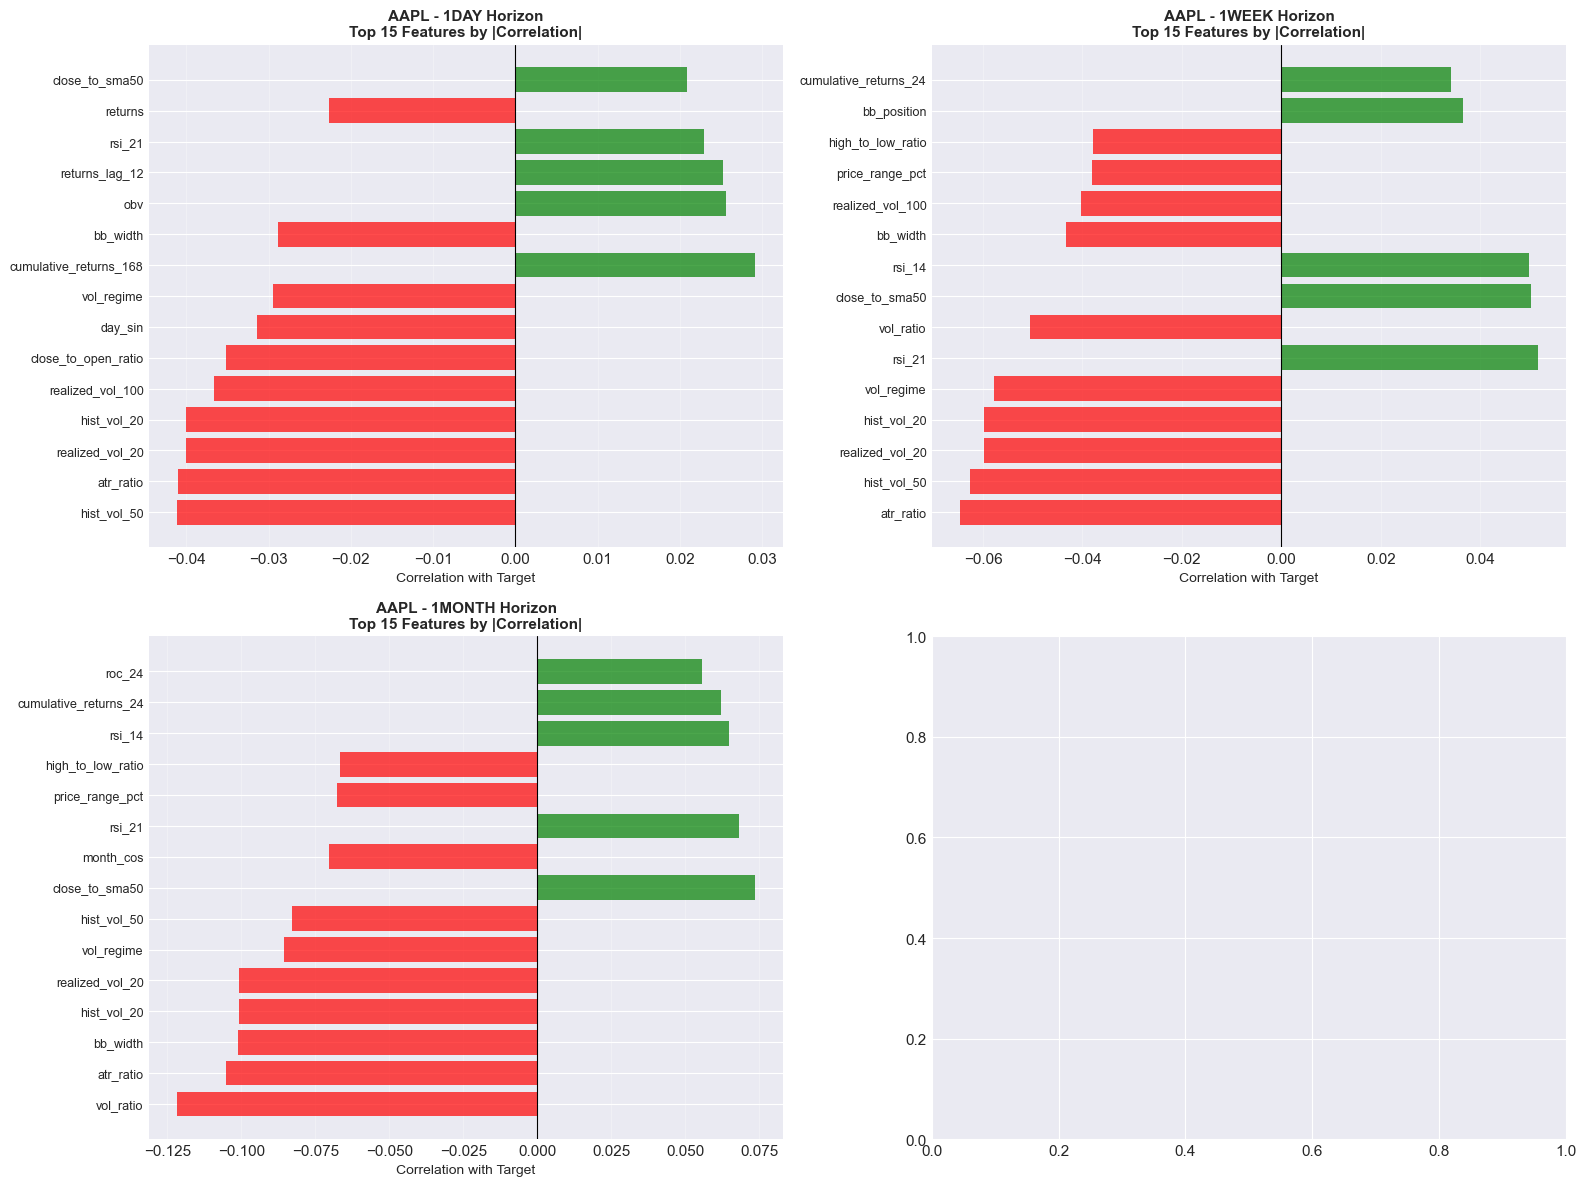

[OK] Feature-target correlation plots generated


In [37]:
# Visualize top feature-target correlations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (horizon_name, corr) in enumerate(feature_target_corr.items()):
    ax = axes[idx]
    
    # Get top 15 features by absolute correlation
    top_features = corr.abs().sort_values(ascending=False).head(15)
    top_corr_values = corr[top_features.index]
    
    # Create bar plot
    colors = ['green' if x > 0 else 'red' for x in top_corr_values]
    ax.barh(range(len(top_corr_values)), top_corr_values.values, color=colors, alpha=0.7)
    ax.set_yticks(range(len(top_corr_values)))
    ax.set_yticklabels(top_corr_values.index, fontsize=9)
    ax.set_xlabel('Correlation with Target', fontsize=10)
    ax.set_title(f'{sample_asset} - {horizon_name.upper()} Horizon\nTop 15 Features by |Correlation|', 
                 fontsize=11, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("[OK] Feature-target correlation plots generated")

## 8. Save Processed Data

Save the engineered features and target variables to disk for use in model training.

In [38]:
print("="*80)
print("SAVING PROCESSED DATA")
print("="*80)

for asset, df in final_data.items():
    # Save full dataset with all features and targets
    filename = f'{PROCESSED_DIR}{asset}_features.csv'
    df.to_csv(filename)
    
    print(f"\n{asset}:")
    print(f"  Saved: {filename}")
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {len(df.columns)}")
    print(f"  Date range: {df.index.min()} to {df.index.max()}")

print("\n" + "="*80)
print("[OK] All processed data saved successfully")
print("="*80)
print(f"\nOutput directory: {PROCESSED_DIR}")

SAVING PROCESSED DATA

AAPL:
  Saved: ../data_new/data_processed/AAPL_features.csv
  Shape: (6303, 64)
  Columns: 64
  Date range: 2000-10-16 00:00:00 to 2025-11-06 00:00:00

AAPL:
  Saved: ../data_new/data_processed/AAPL_features.csv
  Shape: (6303, 64)
  Columns: 64
  Date range: 2000-10-16 00:00:00 to 2025-11-06 00:00:00

AMZN:
  Saved: ../data_new/data_processed/AMZN_features.csv
  Shape: (6303, 64)
  Columns: 64
  Date range: 2000-10-16 00:00:00 to 2025-11-06 00:00:00

AMZN:
  Saved: ../data_new/data_processed/AMZN_features.csv
  Shape: (6303, 64)
  Columns: 64
  Date range: 2000-10-16 00:00:00 to 2025-11-06 00:00:00

NVDA:
  Saved: ../data_new/data_processed/NVDA_features.csv
  Shape: (6303, 64)
  Columns: 64
  Date range: 2000-10-16 00:00:00 to 2025-11-06 00:00:00

NVDA:
  Saved: ../data_new/data_processed/NVDA_features.csv
  Shape: (6303, 64)
  Columns: 64
  Date range: 2000-10-16 00:00:00 to 2025-11-06 00:00:00

SPY:
  Saved: ../data_new/data_processed/SPY_features.csv
  Shape